# Prep all data

In [2]:
import pandas as pd
import duckdb
connection = duckdb.connect(database=':memory:', read_only=False)

capacity_df = pd.read_parquet(r'C:\Users\lt0828\Desktop\PhD\p3\nu1000_model\gcmc\files\trappe_ff\mix.parquet')
capacity_df = capacity_df.loc[:, ['p', 'temperature', 'adsorption_type', 'mol_uc_avg', 'component_num']]
capacity_df = capacity_df.astype({'p': int, 'temperature': int, 'component_num': int, 'mol_uc_avg': float,
                                  'adsorption_type': 'category'})

capacity_df['alken'] = capacity_df['component_num'].apply(lambda x: f'C{(x+1)*2}').astype(str) + \
                            capacity_df['adsorption_type'].apply(lambda x: '' if x == 'absolute' else '_out').astype(str)
print(capacity_df.shape)
s = """
with t1 as (
SELECT * FROM capacity_df where adsorption_type = 'absolute'),
t2 as (
SELECT * FROM capacity_df where adsorption_type = 'excess'),
t3 as (
select t2.*, t1.mol_uc_avg - t2.mol_uc_avg as capacity from t1 join t2 on t1.temperature = t2.temperature 
and t1.component_num = t2.component_num and t1.p = t2.p)

select *, mol_uc_avg as capacity from capacity_df where adsorption_type = 'absolute'
union
select t3.*from t3
order by temperature, p, component_num, adsorption_type
"""
capacity_df = connection.execute(s).fetchdf()
capacity_df.to_pickle('../files/processed_data/capacity_df.pkl')
capacity_df.query('temperature == 300 and p == 100000').head(2)

(1210, 6)


,p,temperature,adsorption_type,mol_uc_avg,component_num,alken,capacity
0,100000,300,absolute,1.554528,0,C2,1.554528
1,100000,300,excess,1.458681,0,C2_out,0.095847


In [2]:
distribution = pd.read_pickle(r'C:\Users\lt0828\Desktop\PhD\p3\nu1000_model\gcmc\files\clusterization\distribution.pkl')\
    .drop(columns=['atom_name']).rename(columns={'T': 'temperature'})
distribution['alken'] = distribution['n'].apply(lambda x: f'C{x}').astype(str)
distribution = distribution[~distribution.file.str.contains('lowT')]
s = '''
with t1 as (
select * from distribution where cluster = 0),
t2 as (
    select d.*, d.N_mol / t1.N_mol as ratio from distribution as d
    left join t1 using(alken, p, temperature))

select * from t2 where cluster == 1
'''
distribution_df = connection.execute(s).fetchdf()
distribution_df.to_pickle('../files/processed_data/distribution_df.pkl')
distribution_df.head(2)

,file,cluster,N_mol,p,temperature,n,G,alken,ratio
0,mixtures_hf/p_100000_T_300/Movies/System_0/Mov...,1,174113,100000,300,2,-0.147839,C2,1.281458
1,mixtures_hf/p_100000_T_300/Movies/System_0/Mov...,1,3830784,100000,300,4,0.083982,C4,0.868594


In [3]:
distribution = pd.read_pickle(r'C:\Users\lt0828\Desktop\PhD\p3\nu1000_model\gcmc\files\clusterization\distribution.pkl')\
    .drop(columns=['atom_name']).rename(columns={'T': 'temperature'})
distribution['alken'] = distribution['n'].apply(lambda x: f'C{x}').astype(str)
distribution = distribution[~distribution.file.str.contains('lowT')]
s = '''
with t1 as (
select * from distribution where cluster = 0),
t2 as (
    select d.*, d.N_mol / t1.N_mol as ratio from distribution as d
    left join t1 using(alken, p, temperature))

select * from t2 where cluster == 1
'''
distribution_df = connection.execute(s).fetchdf()
distribution_df.to_pickle('../files/processed_data/distribution_df.pkl')

c:\Users\lt0828\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(


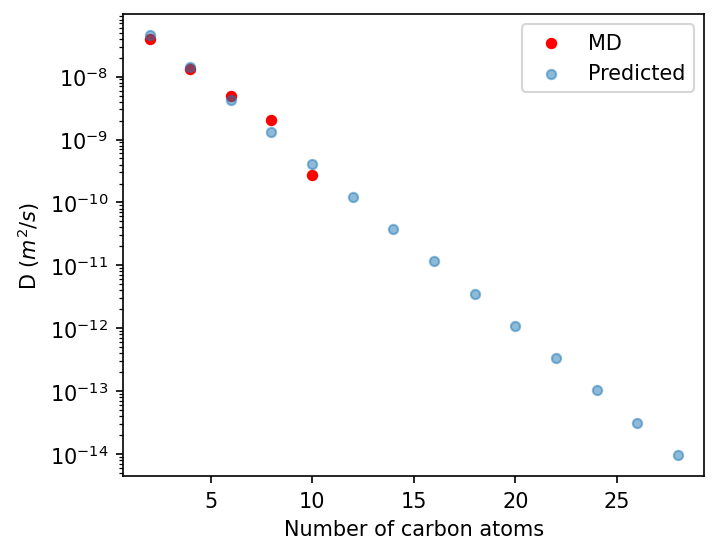

In [4]:
import numpy as np
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=150)
diffusions = pd.DataFrame({'n': [2, 4, 6, 8, 10], 
                           'D': [4.010918e-08, 1.324638e-08, 4.875015e-09, 2.026042e-09, 2.767088e-10]})

diffusions['logd'] = diffusions['D'].apply(lambda x: np.log10(x))
diffusions.plot(x='n', y='D', kind='scatter', ax=ax, color='red', label = 'MD')
model = LassoCV()
model.fit(diffusions[['n']], diffusions['logd'])

# Predict logD up to n = 28 and calculate D
n_pred = np.arange(2, 29, 2)
logd_pred = model.predict(n_pred.reshape(-1, 1))
D_pred = 10**logd_pred

# Create DataFrame for the prediction
diffusion_pred = pd.DataFrame({'n': n_pred, 'D': D_pred, 'logd_pred': logd_pred})
diffusion_pred.plot(x='n', y='D', kind='scatter', ax=ax, label = 'Predicted', alpha=0.5)
plt.yscale('log')
plt.xlabel('Number of carbon atoms')
plt.ylabel('D $(m^2/s)$')
diffusions = pd.concat([diffusions, diffusion_pred])
diffusions.to_pickle('../files/processed_data/diffusion.pkl')

c:\Users\lt0828\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'Capacity $(mol/uc)$')

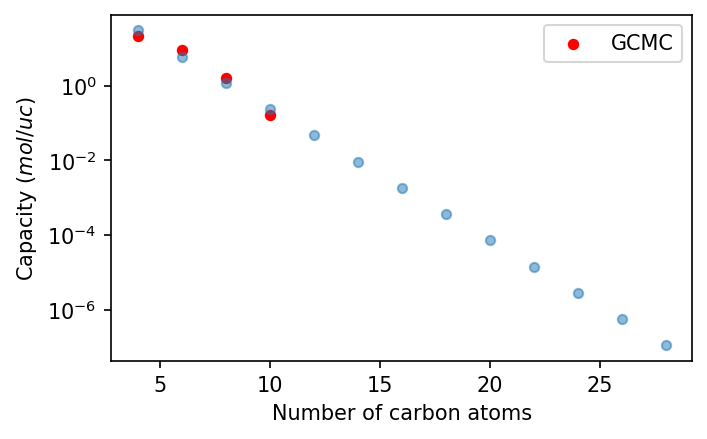

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=150)
df = capacity_df.query('temperature == 300 and p == 100000 and adsorption_type == "absolute" and component_num > 0')\
    [['mol_uc_avg', 'component_num']]
df['n'] = df['component_num'].apply(lambda x: (x+1) * 2)
df['log_capacity'] = np.log10(df['mol_uc_avg'])
df.plot(x='n', y='mol_uc_avg', kind='scatter', ax=ax, color='red', label='GCMC')
model = LassoCV(cv=4)
model.fit(df[['n']], df['log_capacity'])

# Predict logD up to n = 28 and calculate D
n_pred = np.arange(4, 29, 2)
log_capacity_pred = model.predict(n_pred.reshape(-1, 1))
capacity_pred = 10**log_capacity_pred
capacity_pred = pd.DataFrame({'n': n_pred, 'capacity': capacity_pred})
capacity_pred['adsorption_type'] = 'absolute'

capacity_pred.plot(x='n', y='capacity', kind='scatter', ax=ax, alpha=0.5)
ax.set_yscale('log')
ax.set_xlabel('Number of carbon atoms')
ax.set_ylabel('Capacity $(mol/uc)$')

In [6]:
capacity_pred = pd.concat([capacity_pred, pd.DataFrame({'n': n_pred, 'capacity': 17.817100, 'adsorption_type': 'excess'})], axis=0)
capacity_pred.loc[-1] = [2, 1.554528, 'absolute']
capacity_pred.loc[-2] = [2, 0.095847, 'excess']

capacity_pred['component_num'] = capacity_pred['n'].apply(lambda x: (x-2)/2)
capacity_pred['temperature'] = 300
capacity_pred['p'] = 100000
capacity_pred['mol_uc_avg'] = capacity_pred['capacity']

capacity_pred['alken'] = capacity_pred['component_num'].apply(lambda x: f'C{int(x+1)*2}').astype(str) + \
                            capacity_pred['adsorption_type'].apply(lambda x: '' if x == 'absolute' else '_out').astype(str) 
capacity_pred = capacity_pred.sort_values(by=['n', 'adsorption_type']).reset_index(drop=True)

capacity_pred = pd.concat([capacity_df.query('temperature == 300 and p == 100000'), 
                           capacity_pred.query('n>10')])

capacity_pred.to_pickle('../files/processed_data/capacity_pred.pkl')
capacity_pred.head(2)

,p,temperature,adsorption_type,mol_uc_avg,component_num,alken,capacity,n
0,100000,300,absolute,1.554528,0.0,C2,1.554528,NaN
1,100000,300,excess,1.458681,0.0,C2_out,0.095847,NaN


### Profile

In [3]:
import joblib
def read_file(file):
    df = pd.read_csv(file, sep='\s+', skiprows=1, header=None)
    df.columns = ['E', 'type', 'state']
    return df

def energy_diff(init_state, final_state, df):
    E = df.query(f'state == "{init_state}"')['E'].values
    if len(E) != 1:
        raise ValueError(f'{init_state} not found in the dataframe or there is more than one entry')
    init_state_energy = E[0]
    E = df.query(f'state == "{final_state}"')['E'].values
    if len(E) != 1:
        raise ValueError(f'{final_state} not found in the dataframe or there is more than one entry')
    final_state_energy = E[0]
    return final_state_energy - init_state_energy

def make_energies(df):
    if df.shape[0] == 10:
        c2_chemisorb = energy_diff('5', '5,6', df)
        c2_dechemisorb = energy_diff('6', '5,6', df)
    else:
        c2_chemisorb = energy_diff('5', '6', df)
        c2_dechemisorb = energy_diff('6', '5', df)

    energies = {'c2_adsorption': energy_diff('4', '5', df),
    'c2_desorbtion': energy_diff('5', '4', df),
    'c2_chemisorb': c2_chemisorb,
    'c2_dechemisorb': c2_dechemisorb,
    'c2_insertion': energy_diff('1', '1,2', df),
    'c2_deinsertion': energy_diff('2', '1,2', df),
    'c4_adsorption': energy_diff('4', '2', df),
    'c4_desorbtion': energy_diff('2', '4', df)}
    return energies

file = r'../files\raw_data\EtDimer_data\Cr3_PBED3BJ_fm_G_Truhlar.dat'
df = read_file(file)
energies = make_energies(df)
joblib.dump(energies, '../files/processed_data/CrIII_energies.pkl')
df.to_pickle('../files/processed_data/CrIII.pkl')

file = r'../files\raw_data\EtDimer_data\Cr2_PBED3BJ_fm_G_Truhlar.dat'
df = read_file(file)
energies = make_energies(df)
joblib.dump(energies, '../files/processed_data/CrII_energies.pkl')
df.to_pickle('../files/processed_data/CrII.pkl')
file = r'../files\raw_data\EtDimer_data\Ni_PBED3BJ_fm_G-Truhlar.dat'
df = read_file(file)
energies = make_energies(df)
joblib.dump(energies, '../files/processed_data/Ni_energies.pkl')
df.to_pickle('../files/processed_data/Ni.pkl')

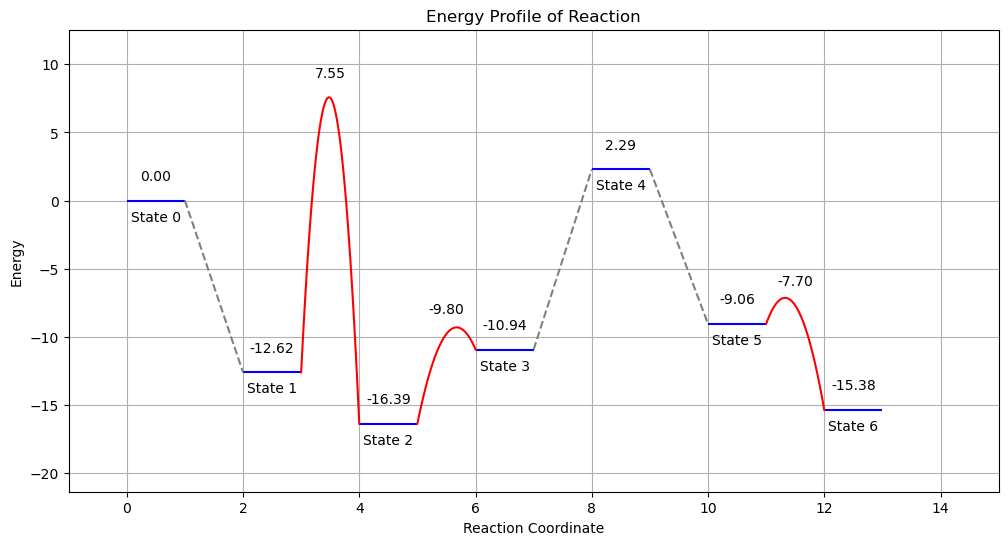

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def parse_ts_states(s):
    """Parse the 'state' column for TS entries to extract connected states."""
    return [int(x.strip()) for x in s.split(',')]

def plot_parabola(ax, x1, x2, E1, E2, x_ts, E_ts):
    """Plot a parabola connecting two intermediates via a transition state."""
    # Fit a quadratic polynomial y = a*x^2 + b*x + c through three points
    x_pts = np.array([x1, x_ts, x2])
    y_pts = np.array([E1, E_ts, E2])
    A = np.vstack([x_pts**2, x_pts, np.ones_like(x_pts)]).T
    # Use least squares in case of overdetermined system
    coeffs = np.linalg.lstsq(A, y_pts, rcond=None)[0]
    a, b, c = coeffs

    # Generate x values for plotting the parabola
    x_vals = np.linspace(x1, x2, 100)
    y_vals = a * x_vals ** 2 + b * x_vals + c

    ax.plot(x_vals, y_vals, color='red')

def plot_energy_profile(df, ax, m=1):
    """Plot the energy profile of a reaction given a DataFrame and an Axes object."""
    # Prepare intermediates
    intermediates = df[df['type'] == 'I'].copy()
    intermediates['state'] = intermediates['state'].astype(int)
    intermediates = intermediates.sort_values('state')

    intermediate_states = intermediates['state'].tolist()

    # Assign x positions to intermediates
    x = 0
    delta = 1  # Gap between events
    positions = {}
    state_to_positions = {}
    state_to_energy = {}

    for idx, row in intermediates.iterrows():
        state = row['state']
        E = row['E']

        x_start = x
        x_end = x + m

        positions[state] = x
        state_to_positions[state] = (x_start, x_end)
        state_to_energy[state] = E

        # Plot intermediate line
        ax.hlines(E, x_start, x_end, colors='blue')

        # Energy value above the line
        x_label_pos = (x_start + x_end) / 2
        ax.text(x_label_pos, E + 1.5, f"{E:.2f}", ha='center')

        # State name below the line
        ax.text(x_label_pos, E - 1.5, f"State {state}", ha='center')

        x += m + delta

    # Prepare TS connections
    df_ts = df[df['type'] == 'TS'].copy()
    ts_connections = {}
    for idx, row in df_ts.iterrows():
        ts_states = parse_ts_states(row['state'])
        s1, s2 = ts_states
        s1 = int(s1)
        s2 = int(s2)
        key = (min(s1, s2), max(s1, s2))
        ts_connections[key] = row['E']

    # Process adjacent intermediates
    for i in range(len(intermediate_states) - 1):
        s1 = intermediate_states[i]
        s2 = intermediate_states[i + 1]
        key = (min(s1, s2), max(s1, s2))

        x1_start, x1_end = state_to_positions[s1]
        x2_start, x2_end = state_to_positions[s2]

        E1 = state_to_energy[s1]
        E2 = state_to_energy[s2]

        if key in ts_connections:
            E_ts = ts_connections[key]

            x1 = x1_end  # End of first intermediate line
            x2 = x2_start  # Start of second intermediate line
            x_ts = (x1 + x2) / 2  # Position of TS

            plot_parabola(ax, x1, x2, E1, E2, x_ts, E_ts)

            # Energy value above the TS
            ax.text(x_ts, E_ts + 1.5, f"{E_ts:.2f}", ha='center')

        else:
            # Plot dashed line
            x_vals = [x1_end, x2_start]
            y_vals = [E1, E2]
            ax.plot(x_vals, y_vals, linestyle='--', color='gray')

    # Set labels and title
    ax.set_xlabel('Reaction Coordinate')
    ax.set_ylabel('Energy')
    ax.set_title('Energy Profile of Reaction')

    # Adjust plot limits for better spacing
    ax.set_xlim(-1, x + 1)
    y_min = df['E'].min() - 5
    y_max = df['E'].max() + 5
    ax.set_ylim(y_min, y_max)
    ax.grid(True)

# Sample DataFrame
data = {
    'E': [0.000000, -52.807702, -68.576759, -45.786958, 9.573874,
          -37.908489, -64.356256, 31.574096, -40.992500, -32.236150],
    'type': ['I', 'I', 'I', 'I', 'I', 'I', 'I', 'TS', 'TS', 'TS'],
    'state': ['0', '1', '2', '3', '4', '5', '6', '1,2', '2,3', '5,6']
}



df = pd.DataFrame(data)
df.loc[:, 'E'] = df.loc[:, 'E']/4.184
# Usage Example
fig, ax = plt.subplots(figsize=(12, 6))
plot_energy_profile(df, ax, m=1)
plt.show()

# Reaction

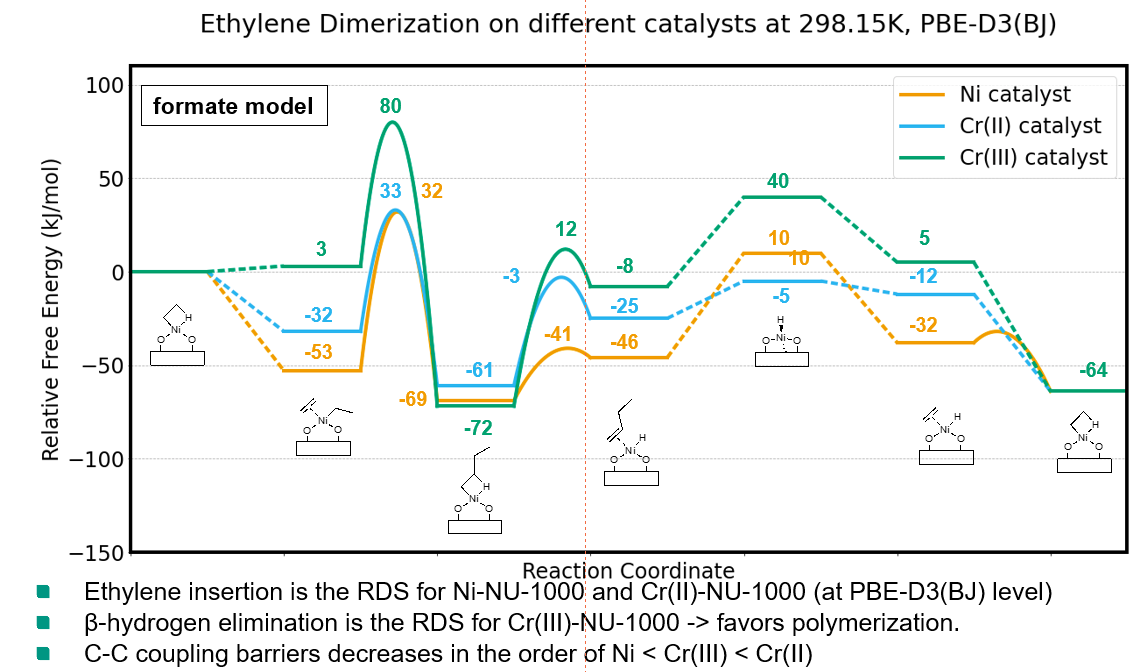

In [1]:
import sys
import os
import pandas as pd
import re
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import numpy as np
sys.path.insert(0, os.path.abspath('../src'))
from model_linear import *
from some_functions import *
from reaction_list_creator import *
from diffusion import Reaction_Diffusion

In [2]:
diffusion_pred = pd.read_pickle('../files/processed_data/diffusion_pred.pkl')
capacity_pred = pd.read_pickle('../files/processed_data/capacity_pred.pkl')

L = 20 #nm
n = L/3
diffusion_pred['flux'] = diffusion_pred['D'] / (L * 1e-9)
diffusion_dict = diffusion_pred.set_index('n')['flux'].to_dict()

crII = joblib.load('../files/processed_data/CrII_energies.pkl')
ni = joblib.load('../files/processed_data/Ni_energies.pkl')
crIII = joblib.load('../files/processed_data/CrIII_energies.pkl')
capacity = pd.read_pickle('../files/processed_data/capacity_pred.pkl').query(f'temperature == 300 and p == 100000').set_index('alken')['capacity'].to_dict()

<Axes: xlabel='n', ylabel='probability'>

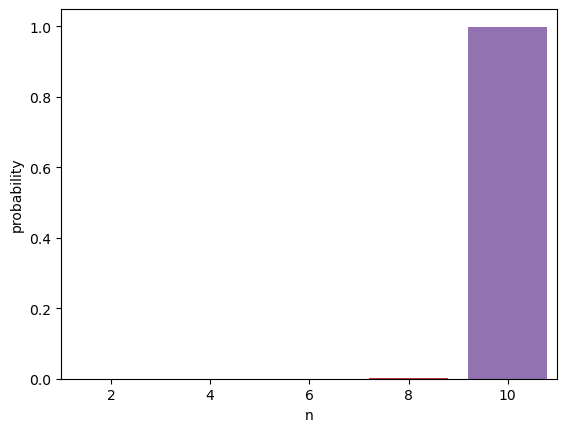

In [3]:
def run_model(reaction_list, capacity, hours=10, n_steps=1e4, c2_conc=1.5, cat_conc=1e-2):
    r = Reaction_Diffusion(reaction_list, capacity=capacity)
    start_time = 0
    end_time = 60 * 60 * hours
    n_steps = int(n_steps)
    result = r.solve({'Cat': cat_conc, 'C2': c2_conc}, np.linspace(start_time, end_time, n_steps))
    return result, r

def calc_distribution(result):
    pat = re.compile(r'\bC(\d+)')
    columns = list(filter(lambda x: pat.match(x), result.columns.values))
    df = result[columns].iloc[-1:]
    df = df.mean()
    df = df.reset_index(name='concentration')
    df['n'] = df['index'].str.extract(r'(\d+)')[0].astype(int)
    df = df.groupby('n').sum(numeric_only=True)
    df['probability'] = df['concentration'] / df.loc[4:, 'concentration'].sum()
    df.loc[2, 'probability'] = np.nan
    return df.reset_index()

reaction_dict = {'c2_ins_barrier': 0, 'c2_barrier': None, 
                 'c2_chem_barrier' :None, 'c4_barrier': 0, 
                 'c4_chem_barrier' :None}

N = 10
constants = prepare_constants(N, crII, borders=(1e-7, 1e7), 
                              diffusion_dict=diffusion_dict, **reaction_dict)

reaction_list = make_reaction_list_with_diffusion(N, constants, constants['k_diffusion_dict'])
# reaction_list = make_reaction_list_basic(N, constants)
results, r = run_model(reaction_list, capacity, hours=10, n_steps=1e4, c2_conc=1.5, cat_conc=1e-2)

df = calc_distribution(results)
sns.barplot(x='n', y='probability', data=df)

In [4]:
reaction_list

[['Cat + C2 <-> CatC2', 10000000.0, 10000000.0],
 ['CatC2 + C2 <-> CatC4', 30.04933181801927, 0.0002681043852819169],
 ['Cat + C4 <-> CatC4', 10000000.0, 1108.9976260868311],
 ['CatC4 + C2 <-> CatC6', 30.04933181801927, 0.0002681043852819169],
 ['Cat + C6 <-> CatC6', 10000000.0, 1108.9976260868311],
 ['CatC6 + C2 <-> CatC8', 30.04933181801927, 0.0002681043852819169],
 ['Cat + C8 <-> CatC8', 10000000.0, 1108.9976260868311],
 ['CatC8 + C2 <-> CatC10', 30.04933181801927, 0.0002681043852819169],
 ['Cat + C10 <-> CatC10', 10000000.0, 1108.9976260868311],
 ['C2 <D> C2_out', 2.2799124864955975, 2.2799124864955975],
 ['C4 <D> C4_out', 0.6992668289358527, 0.6992668289358527],
 ['C6 <D> C6_out', 0.2144705557543545, 0.2144705557543545],
 ['C8 <D> C8_out', 0.06577978159722113, 0.06577978159722113],
 ['C10 <D> C10_out', 0.020175168809344862, 0.020175168809344862]]

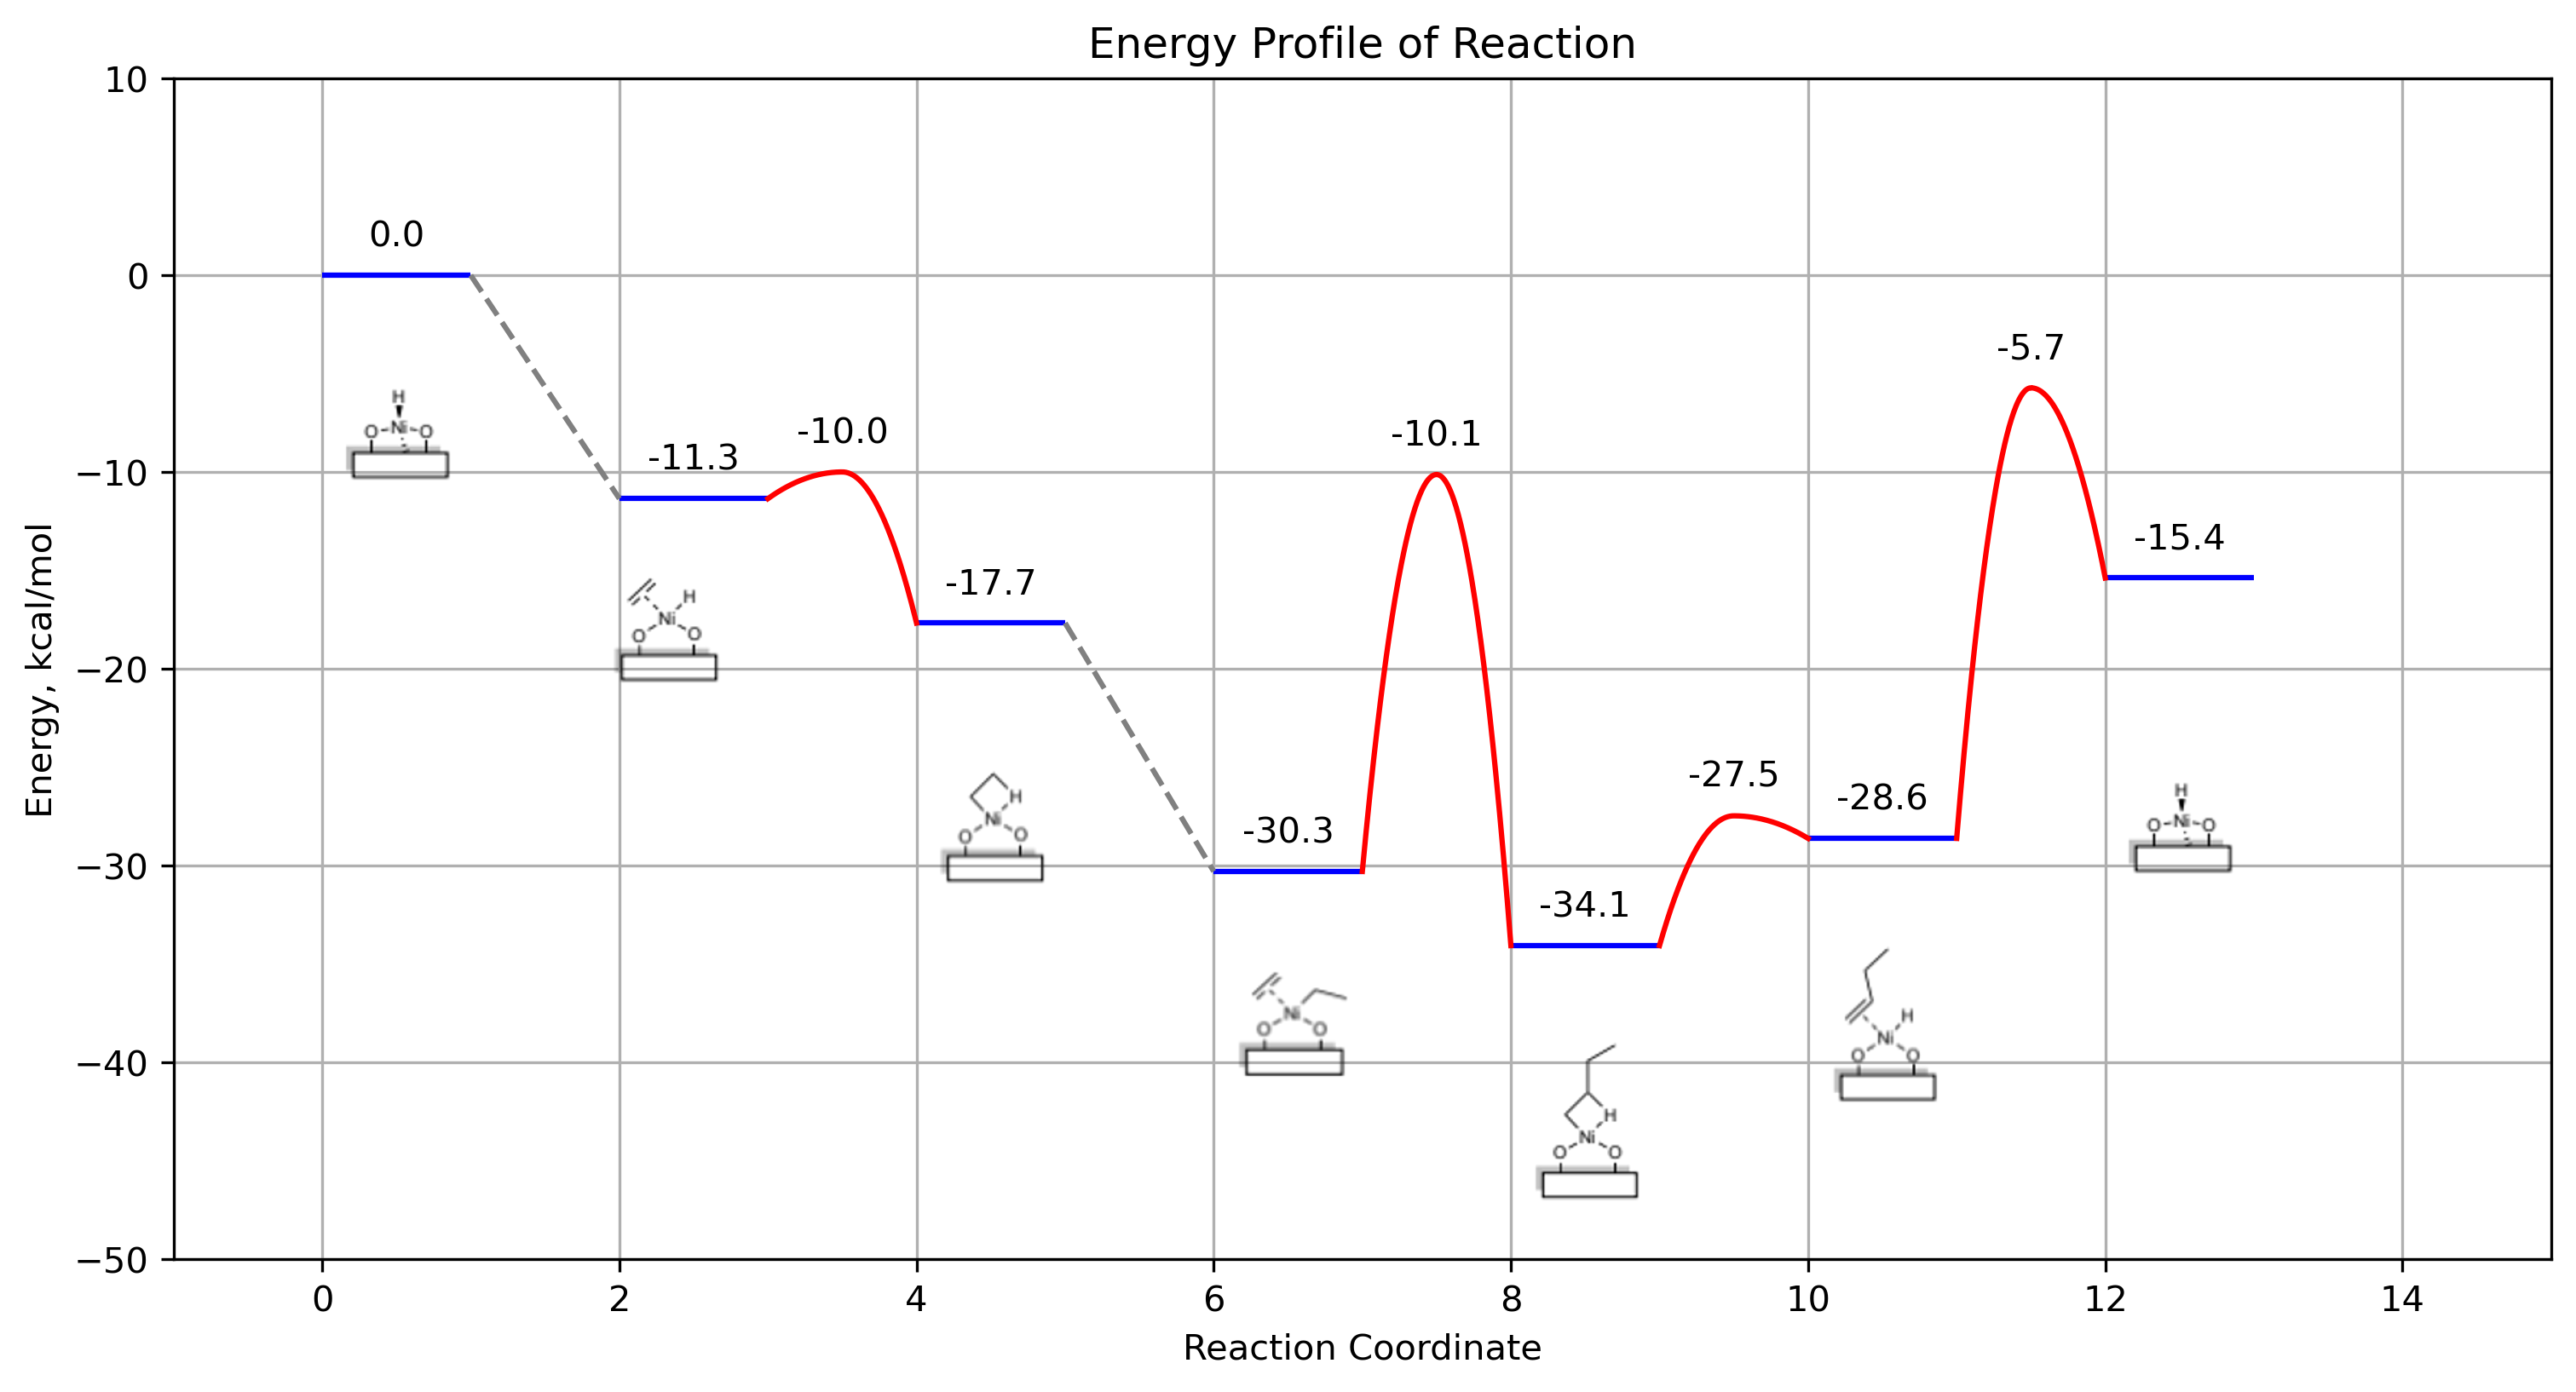

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os


def add_images_to_plot(ax):
    """
    Adds images to a given matplotlib Axes object.

    Parameters:
    ax (matplotlib.axes._axes.Axes): The matplotlib Axes object where the images will be added.
    """
    # File paths for the images
    image_paths = [
        "../files/processed_data/reaction/Picture5.png",
        "../files/processed_data/reaction/Picture6.png",
        "../files/processed_data/reaction/Picture1.png",
        "../files/processed_data/reaction/Picture2.png",
        "../files/processed_data/reaction/Picture3.png",
        "../files/processed_data/reaction/Picture4.png",
        "../files/processed_data/reaction/Picture5.png",
    ]

    # Coordinates of the images
    x_coords = [0.5, 2.3, 4.5, 6.5, 8.5, 10.5, 12.5, 14.5, 16.5]
    y_coords = np.array([ -5, -15, -25. , -35., -40, -35., -25, -35, -40])
    y_coords = y_coords - 3
    # Loop through each image and add it to the plot
    for i, image_path in enumerate(image_paths):
        if os.path.exists(image_path):
            # Read the image
            img = plt.imread(image_path)
            image_box = OffsetImage(img, zoom=0.3)  # Adjust the zoom level as needed

            # Create an AnnotationBbox and add it to the axis
            ab = AnnotationBbox(image_box, (x_coords[i], y_coords[i]), frameon=False)
            ax.add_artist(ab)
        else:
            print(f"Warning: Image file not found: {image_path}")

def parse_ts_states(s):
    """Parse the 'state' column for TS entries to extract connected states."""
    return [int(x.strip()) for x in s.split(',')]

def plot_parabola(ax, x1, x2, E1, E2, x_ts, E_ts):
    """Plot a parabola connecting two intermediates via a transition state."""
    # Fit a quadratic polynomial y = a*x^2 + b*x + c through three points
    x_pts = np.array([x1, x_ts, x2])
    y_pts = np.array([E1, E_ts, E1])
    A = np.vstack([x_pts**2, x_pts, np.ones_like(x_pts)]).T
    # Use least squares in case of overdetermined system
    coeffs = np.linalg.lstsq(A, y_pts, rcond=None)[0]
    a0, b0, c0 = coeffs

    x_pts = np.array([x1, x_ts, x2])
    y_pts = np.array([E2, E_ts, E2])
    A = np.vstack([x_pts**2, x_pts, np.ones_like(x_pts)]).T
    # Use least squares in case of overdetermined system
    coeffs = np.linalg.lstsq(A, y_pts, rcond=None)[0]
    a1, b1, c1 = coeffs

    # Generate x values for plotting the parabola
    x_vals0 = np.linspace(x1, x_ts, 100)
    y_vals0 = a0 * x_vals0 ** 2 + b0 * x_vals0 + c0
    
    x_vals1 = np.linspace(x_ts, x2, 100)
    y_vals1 = a1 * x_vals1 ** 2 + b1 * x_vals1 + c1

    x_vals = np.concatenate([x_vals0, x_vals1])
    y_vals = np.concatenate([y_vals0, y_vals1])

    ax.plot(x_vals, y_vals, color='red')

def plot_energy_profile(df, ax, m=1):
    """Plot the energy profile of a reaction given a DataFrame and an Axes object."""
    # Prepare intermediates
    intermediates = df[df['type'] == 'I'].copy()
    intermediates['state'] = intermediates['state'].astype(int)
    intermediates = intermediates.sort_values('state')

    intermediate_states = intermediates['state'].tolist()

    # Assign x positions to intermediates
    x = 0
    delta = 1  # Gap between events
    positions = {}
    state_to_positions = {}
    state_to_energy = {}

    for idx, row in intermediates.iterrows():
        state = row['state']
        E = row['E']

        x_start = x
        x_end = x + m

        positions[state] = x
        state_to_positions[state] = (x_start, x_end)
        state_to_energy[state] = E

        # Plot intermediate line
        ax.hlines(E, x_start, x_end, colors='blue')

        # Energy value above the line
        x_label_pos = (x_start + x_end) / 2
        ax.text(x_label_pos, E + 1.5, f"{E:.1f}", ha='center')

        # State name below the line
        # ax.text(x_label_pos, E - 1.5, f"State {state}", ha='center')

        x += m + delta

    # Prepare TS connections
    df_ts = df[df['type'] == 'TS'].copy()
    ts_connections = {}
    for idx, row in df_ts.iterrows():
        ts_states = parse_ts_states(row['state'])
        s1, s2 = ts_states
        s1 = int(s1)
        s2 = int(s2)
        key = (min(s1, s2), max(s1, s2))
        ts_connections[key] = row['E']

    # Process adjacent intermediates
    for i in range(len(intermediate_states) - 1):
        s1 = intermediate_states[i]
        s2 = intermediate_states[i + 1]
        key = (min(s1, s2), max(s1, s2))

        x1_start, x1_end = state_to_positions[s1]
        x2_start, x2_end = state_to_positions[s2]

        E1 = state_to_energy[s1]
        E2 = state_to_energy[s2]

        if key in ts_connections:
            E_ts = ts_connections[key]

            x1 = x1_end  # End of first intermediate line
            x2 = x2_start  # Start of second intermediate line
            x_ts = (x1 + x2) / 2  # Position of TS

            plot_parabola(ax, x1, x2, E1, E2, x_ts, E_ts)

            # Energy value above the TS
            ax.text(x_ts, E_ts + 1.5, f"{E_ts:.1f}", ha='center')

            # TS name below the TS
            
        else:
            # Plot dashed line
            x_vals = [x1_end, x2_start]
            y_vals = [E1, E2]
            ax.plot(x_vals, y_vals, linestyle='--', color='gray')

    # Set labels and title
    ax.set_xlabel('Reaction Coordinate')
    ax.set_ylabel('Energy, kcal/mol')
    ax.set_title('Energy Profile of Reaction')

    # Adjust plot limits for better spacing
    ax.set_xlim(-1, x + 1)
    y_min = df['E'].min() - 5
    y_max = df['E'].max() + 5
    ax.set_ylim(y_min, y_max)
    ax.grid(True)
    add_images_to_plot(ax)
    ax.set_ylim(-50, 10)

# Sample DataFrame

en_prof = {
'E': [
    9.573874 + 64.356256,
    -37.908489 + 64.356256, 0.000000, -52.807702, -68.576759, -45.786958, 9.573874,
    5.672339059999999 -37.908489 + 64.356256 ,31.574096, -40.992500, 50],
'type': ['I', 'I', 'I', 'I', 'I', 'I', 'I', 'TS', 'TS', 'TS', 'TS'],
'state': ['0', '1', '2', '3', '4', '5', '6',  '1,2', '3,4', '4,5', '5,6']
}

df = pd.DataFrame(en_prof)
df['E'] -= df.iloc[0, 0]
df['E'] = df['E'] / 4.184
# Usage Example
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
plot_energy_profile(df, ax, m=1)
plt.show()

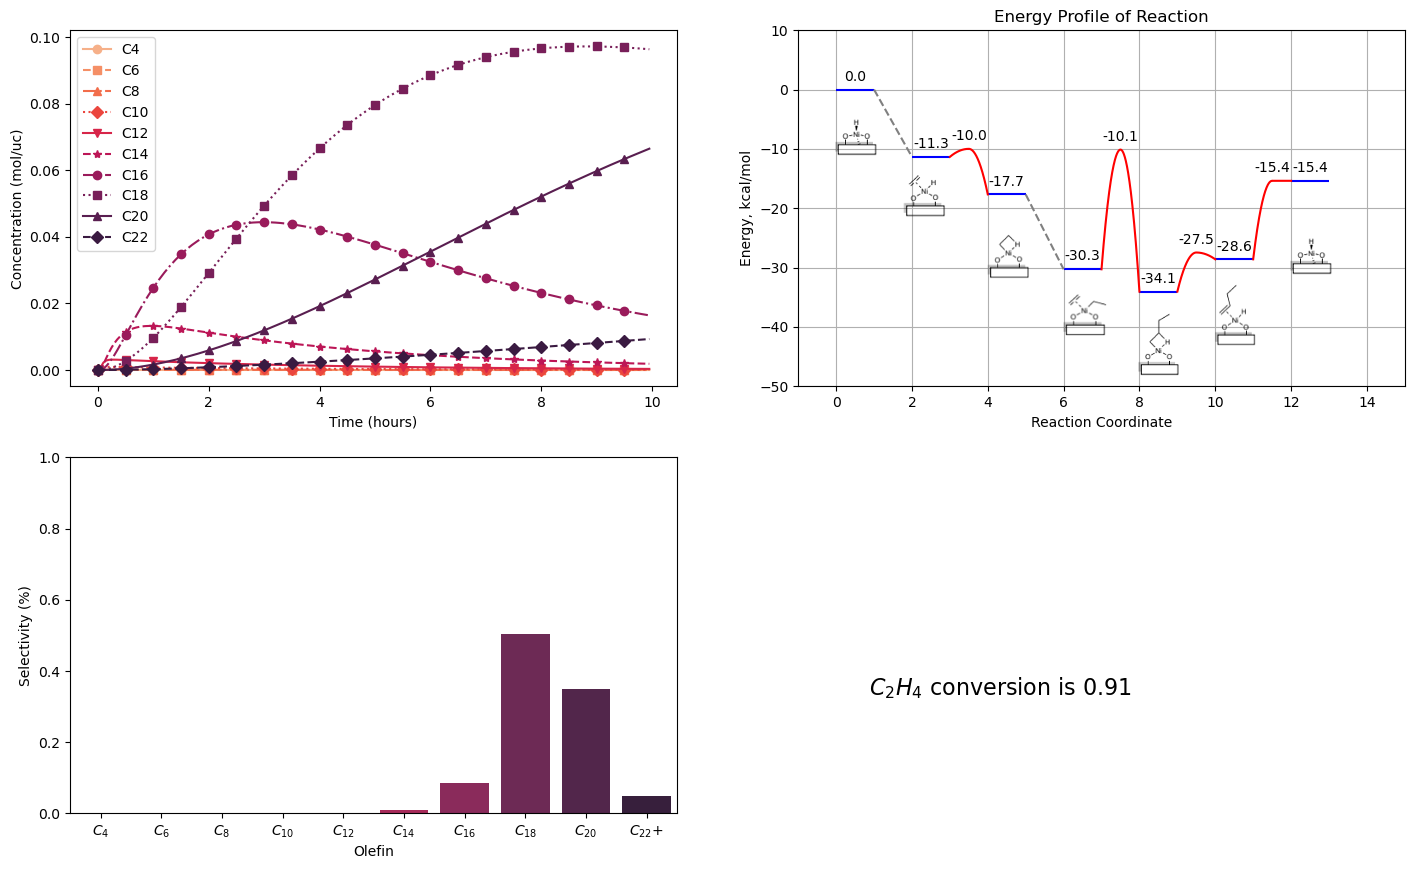

In [8]:
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import itertools

def update_plot(c2_ins_barrier, c4_barrier, is_diffusion, hours, cat_conc, c2_conc, N):
    """
    Update the plots based on the current slider values and checkbox state.

    Parameters:
    - c2_ins_barrier: float, value for c2 insertion barrier
    - c4_barrier: float, value for c4 barrier
    - is_diffusion: bool, whether to include diffusion in the model
    - hours: float, duration in hours for the run_model function
    - cat_conc: float, catalyst concentration
    - c2_conc: float, C2 concentration
    """
    N = int(N)
    # Clear the previous plots
    for ax in axs.flatten():
        ax.clear()
    
    # axs[1, 1].set_visible(False)  # Hides axs[1,1] from the figure

    # Define the carbon numbers and create a consistent color palette
    carbons = list(range(2, N+1, 2))  # For even-numbered carbons
    colors_list = sns.color_palette('rocket', 12)[::-1]  # Or any palette you prefer
    color_dict = {carbon: color for carbon, color in zip(carbons, colors_list)}

    # Define line styles and markers
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D', 'v', '*']
    line_style_cycle = itertools.cycle(line_styles)
    marker_cycle = itertools.cycle(markers)


    # Prepare reaction dictionary
    reaction_dict = {
        'c2_ins_barrier': c2_ins_barrier,
        'c2_barrier': None, 
        'c2_chem_barrier': None,
        'c4_barrier': c4_barrier, 
        'c4_chem_barrier': None
    }

    constants = prepare_constants(
        N, ni, borders=(1e-7, 1e7), diffusion_dict=diffusion_dict, **reaction_dict
    )
    
    # Choose the reaction list based on the diffusion setting
    if is_diffusion:
        reaction_list = make_reaction_list_with_diffusion(N, constants, constants['k_diffusion_dict'])
    else:
        reaction_list = make_reaction_list_basic(N, constants)
        
    # Run the model
    results, _ = run_model(
        reaction_list, capacity, hours=hours, n_steps=1e4, c2_conc=c2_conc, cat_conc=cat_conc
    )

    # Calculate and plot distribution
    df = calc_distribution(results)
    # Create a palette mapping 'n' to colors
    palette = {n: color_dict[n] for n in df['n'].unique()}
    sns.barplot(x='n', y='probability', data=df[1:], ax=axs[1, 0], palette=palette,)


    en_prof = {
    'E': [
        9.573874 + 64.356256,
        -37.908489 + 64.356256, 0.000000, -52.807702, -68.576759, -45.786958, 9.573874,
        5.672339059999999 -37.908489 + 64.356256 ,31.574096, -40.992500, ],
    'type': ['I', 'I', 'I', 'I', 'I', 'I', 'I', 'TS', 'TS', 'TS', ],
    'state': ['0', '1', '2', '3', '4', '5', '6',  '1,2', '3,4', '4,5', ]
    }
    en_prof = pd.DataFrame(en_prof)
    en_prof['E'] -= en_prof.iloc[0, 0]
    en_prof.loc[:, 'E'] = en_prof.loc[:, 'E']/4.184

    if c4_barrier is not None:
        val = c4_barrier + en_prof.loc[en_prof.state == '6', 'E'].values[0]
        en_prof.loc[10] = [val, 'TS', '5,6']

    en_prof.loc[en_prof.state == '3,4', 'E'] += c2_ins_barrier

    plot_energy_profile(en_prof, axs[0, 1], m=1)
    
    # Plot results over time
    # results.loc[:, [f'C{i}' for i in range(2, N+1, 2)]] + results.loc[:, [f'C{i}_out' for i in range(2, N+1, 2)]].values
    dft = results.copy()
    if is_diffusion:
        dft.loc[:, [f'C{i}' for i in range(2, N+1, 2)]] += dft.loc[:, [f'C{i}_out' for i in range(2, N+1, 2)]].values
    dft.index = dft.index / 3600
    # Determine the columns to plot
    columns_to_plot = [f'C{i}' for i in range(4, N+1, 2)]

    # Plot each olefin individually with different styles and markers
    for col in columns_to_plot:
        color = color_dict[int(col[1:])]
        ls = next(line_style_cycle)
        marker = next(marker_cycle)
        dft[col][::50].plot(
            ax=axs[0, 0],
            color=color,
            linestyle=ls,
            marker=marker,
            markevery=10,
            label=f'C{int(col[1:])}'
        )
    # Add legend to axs[1]
    axs[0, 0].legend()
    # Set plot labels and limits
    if N < 16:
        olefines = [f'$C_{{{i}}}H_{{{i*2}}}$' for i in range(4, N+1, 2)]
    else:
        olefines = [f'$C_{{{i}}}$' for i in range(4, N+1, 2)]

    olefines[-1] += '+'
    axs[1, 0].set_xticklabels(olefines)
    axs[1, 0].set_xlabel('Olefin')
    axs[1, 0].set_ylabel('Selectivity (%)')
    axs[1, 0].set_ylim(0, 1)
    axs[0, 0].set_xlabel('Time (hours)')
    axs[0, 0].set_ylabel('Concentration (mol/uc)')

    axs[1, 1].text(1, 1, '$C_2H_4$ conversion is {:4.2f}'.format(1-df.loc[0, 'concentration']/c2_conc),
                   fontsize=16, ha='center')
    axs[1, 1].axis('off')
    axs[1, 1].set_xlim(0, 3)
    axs[1, 1].set_ylim(0, 3)
    canvas.draw()

def on_control_change(event=None):
    """
    Handle changes in sliders and checkbox, updating the plot accordingly.
    """
    c2_ins_barrier = a_slider.get()
    c4_barrier = b_slider.get()
    is_diffusion = is_diffusion_var.get()
    hours = hours_slider.get()
    cat_conc = cat_conc_slider.get()
    c2_conc = c2_conc_slider.get()
    N = int(N_slider.get())  # Ensure N is an integer
    update_plot(c2_ins_barrier, c4_barrier, is_diffusion, hours, cat_conc, c2_conc, N)

def create_gui(slider_params):
    """
    Set up the Tkinter GUI, including sliders, checkbox, and plot area.

    Parameters:
    - slider_params: dict, contains configurations for each slider including label, from_, to, resolution, default
    """
    # Set up the Tkinter window
    root = tk.Tk()
    root.title("Distribution")

    # Set up the plot figure and axes
    global fig, axs, canvas
    fig, axs = plt.subplots(2, 2, figsize=(10, 5))

    # Create a canvas to display the plot in the Tkinter window
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=1)

    # Frame for controls
    control_frame = ttk.Frame(root)
    control_frame.pack(side=tk.RIGHT, fill=tk.Y, padx=10, pady=10)

    # Dictionary to hold slider widgets
    sliders = {}

    # For each slider in slider_params, create the slider dynamically
    for slider_name, params in slider_params.items():
        label = params.get('label', slider_name)
        from_ = params.get('from_', 0)
        to = params.get('to', 1)
        resolution = params.get('resolution', 0.1)
        default = params.get('default', (from_ + to) / 2)

        # Create label for the slider
        slider_label = ttk.Label(control_frame, text=f"{label}:")
        slider_label.pack(pady=5)

        # Create the slider widget
        slider = tk.Scale(
            control_frame,
            from_=from_,
            to=to,
            orient='horizontal',
            resolution=resolution,
            command=on_control_change
        )
        slider.set(default)
        slider.pack(pady=5)

        # Save the slider to the sliders dictionary and as a global variable
        sliders[slider_name] = slider
        globals()[slider_name] = slider  # Makes the slider accessible globally

    # Checkbox for diffusion
    global is_diffusion_var
    is_diffusion_var = tk.BooleanVar(value=True)
    diffusion_check = ttk.Checkbutton(
        control_frame,
        text='Include Diffusion',
        variable=is_diffusion_var,
        command=on_control_change
    )
    diffusion_check.pack(pady=10)

    # Initial plot using default slider values
    update_plot(
        a_slider.get(),
        b_slider.get(),
        is_diffusion_var.get(),
        hours_slider.get(),
        cat_conc_slider.get(),
        c2_conc_slider.get(),
        int(N_slider.get())
    )

    # Start the Tkinter event loop
    root.mainloop()

slider_params = { 'a_slider': {
        'label': 'Insertion Barrier',
        'from_': -15,
        'to': 15,
        'resolution': 0.05,
        'default': 0
    },
    'b_slider': {
        'label': 'C4 desorp Barrier',
        'from_': 0,
        'to': 20,
        'resolution': 0.05,
        'default': 0
    },
    'hours_slider': {
        'label': 'Hours',
        'from_': 1,
        'to': 100,
        'resolution': 0.5,
        'default': 10
    },
    'cat_conc_slider': {
        'label': 'Catalyst Concentration (mol/uc)',
        'from_': 0.005,
        'to': 1,
        'resolution': 0.005,
        'default': 0.005
    },
    'c2_conc_slider': {
        'label': 'C2 Concentration (mol/uc)',
        'from_': 1,
        'to': 150,
        'resolution': 1,
        'default': 1.5
    },
    'N_slider': {
        'label': 'N (Number of Carbons)',
        'from_': 8,
        'to': 22,
        'resolution': 2,
        'default': 10
    }}

create_gui(slider_params)